<a href="https://colab.research.google.com/github/vardanagarwal/SIH/blob/master/Segmentation_unet_cluster_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8MB 42kB/s 
     |████████████████████████████████| 3.9MB 6.3MB/s 
     |████████████████████████████████| 450kB 54.1MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=904c79b18ef36d60433e0f4f03b2a6846a521277a3f9fe9d7b3863c093da5deb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstall

In [0]:
import zipfile
zf = zipfile.ZipFile('/content/drive/My Drive/sky_segmentation/1_training.zip', "r")
zf.extractall()
zf1 = zipfile.ZipFile('/content/drive/My Drive/sky_segmentation/1_testing.zip', "r")
zf1.extractall()
zf2 = zipfile.ZipFile('/content/drive/My Drive/sky_segmentation/mask.zip', "r")
zf2.extractall()

In [0]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import random
import re
from PIL import Image
import cv2
import re
import pandas as pd
import threading
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler

Removing corrupt images

In [6]:
train_imgs = glob("1_training/*.jpg")
print(len(train_imgs))
train_remove = pd.read_csv('/content/drive/My Drive/sky_segmentation/corrupt_training_1.csv')
train_names = train_remove.name
for train_name in train_names:
  pth = os.path.join('1_training', train_name)
  os.remove(pth)
train_imgs = glob("1_training/*.jpg")
print(len(train_imgs))

test_imgs = glob("1_testing/*.jpg")
print(len(test_imgs))
test_remove = pd.read_csv('/content/drive/My Drive/sky_segmentation/corrupt_testing_1.csv')
test_names = test_remove.name
for test_name in test_names:
  pth = os.path.join('1_testing', test_name)
  os.remove(pth)
test_imgs = glob("1_testing/*.jpg")
print(len(test_imgs))


24306
24159
5972
5927


In [7]:
train_imgs = glob("1_training/*.jpg")
test_imgs = glob("1_testing/*.jpg")

print(len(train_imgs))
for train_img in train_imgs:
  camid = re.split('-', re.split('/', train_img)[-1])[-0]
  if camid == '1093' or camid == '5021':
    os.remove(train_img)
train_imgs = glob("1_training/*.jpg")
print(len(train_imgs))

print(len(test_imgs))
for test_img in test_imgs:
  camid = re.split('-', re.split('/', test_img)[-1])[-0]
  if camid == '1093' or camid == '5021':
    os.remove(test_img)
test_imgs = glob("1_testing/*.jpg")
print(len(test_imgs))


24159
23501
5927
5761


In [0]:
train_imgs = glob("1_training/*.jpg")
TRAIN_LENGTH = len(train_imgs)

test_imgs = glob("1_testing/*.jpg")
TEST_LENGTH = len(test_imgs)

BATCH_SIZE = 64
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [0]:
def data_gen(img_folder, batch_size):
    c = 0
    n = os.listdir(img_folder) #List of training images
    random.shuffle(n)
        
    while (True):
        img = np.zeros((batch_size, 224, 224, 3)).astype('float')
        mask = np.zeros((batch_size, 224, 224, 1)).astype('float')
      
        #initially from 0 to 16, c = 0. 
        
        for i in range(c, c+batch_size):
            #print(i)
            train_img = cv2.imread(img_folder+'/'+n[i])/255.
            train_img =  cv2.resize(train_img, (224, 224))# Read an image from folder and resize
            
            img[i-c] = train_img #add to array - img[0], img[1], and so on.
            
            
            mask_path = re.sub("1_training", "mask", img_folder+'/'+n[i])
            mask_path = re.sub("1_testing", "mask", mask_path)
            mask_path = re.sub("jpg", "png", mask_path)
            camid = re.split('-', re.split('/', mask_path)[-1])[-0]
            mask_path = re.sub(r'[0-9_-]+', camid, mask_path)
            #print(mask_path)
            train_mask = cv2.imread(mask_path)
            train_mask = cv2.cvtColor(train_mask, cv2.COLOR_BGR2GRAY)
            train_mask = cv2.resize(train_mask, (224, 224))
            train_mask = train_mask.reshape(224, 224, 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]
            
            mask[i-c] = train_mask
          
        c+=batch_size
        if(c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
                      # print "randomizing again"
        yield img, mask

In [10]:
OUTPUT_CHANNELS = 2
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = True
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)
model = unet_model(OUTPUT_CHANNELS)
adam = tf.keras.optimizers.Adam(lr = 1e-4)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'mse'])
# tf.keras.utils.plot_model(model, show_shapes=True)


9412608/9406464 [==============================] - 1s 0us/step


In [0]:
train_frame_path = '1_training'
test_frame_path = '1_testing'

# Train the model
#datagenerator = createBatchGenerator(BATCH_SIZE)
train_gen = data_gen(train_frame_path, BATCH_SIZE)
test_gen = data_gen(test_frame_path, BATCH_SIZE)

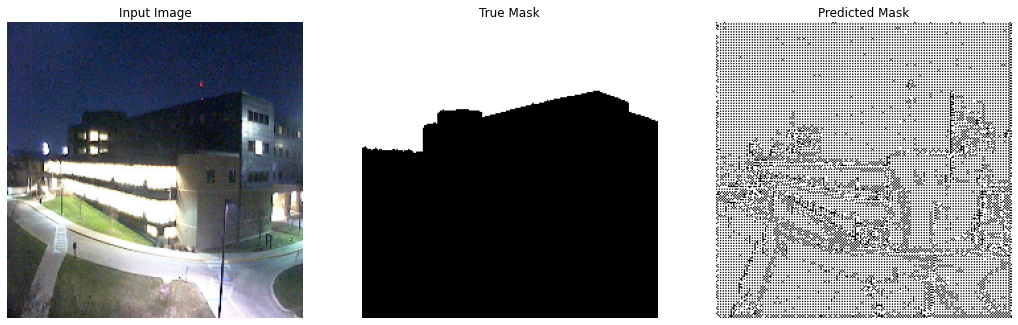

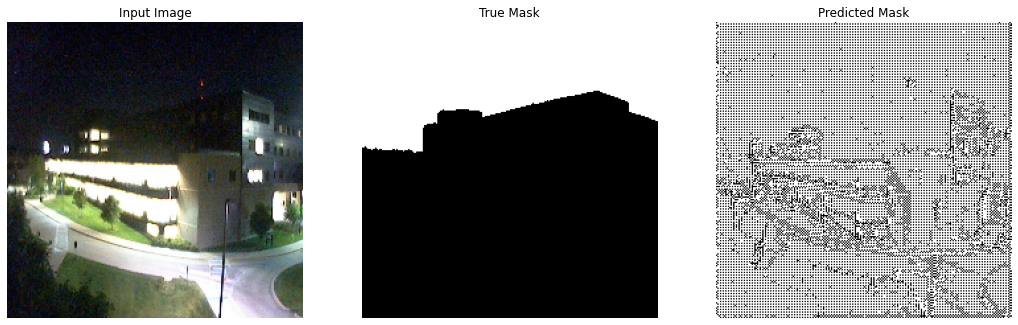

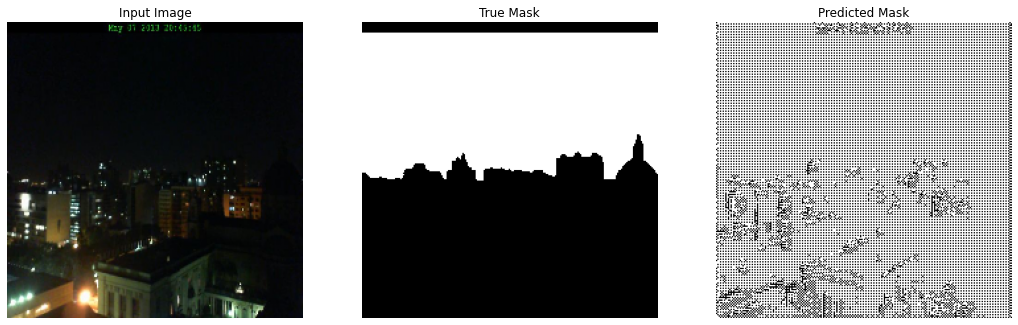

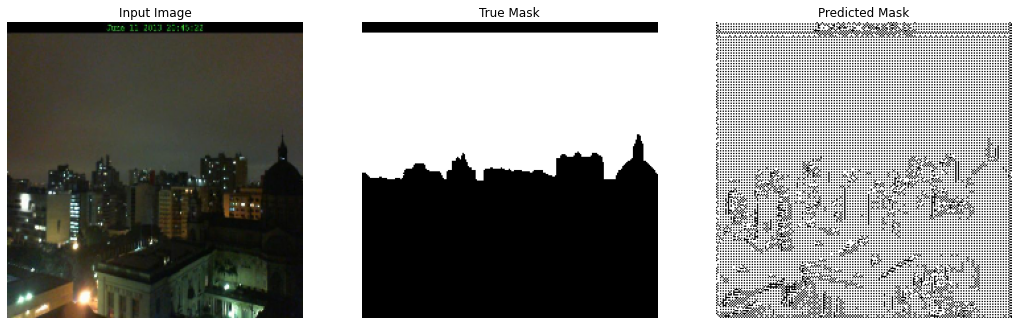

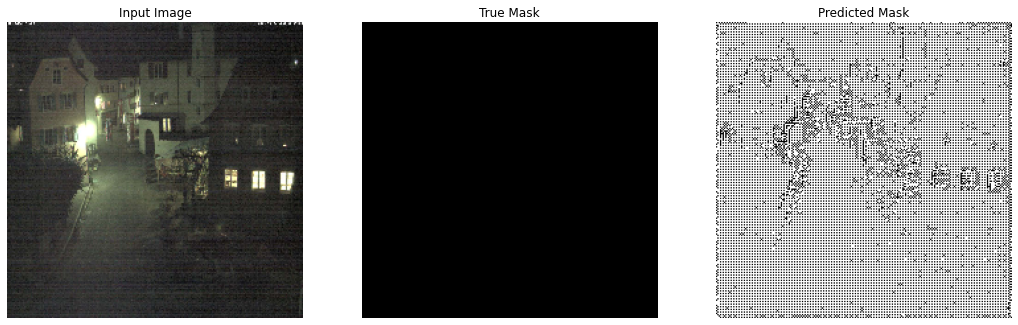

In [13]:
def display_sample(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 2:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
        else:
            plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

# sample_image = cv2.resize(cv2.imread('0_testing/65-20130101_143305.jpg'), (224,224))/255.
# sample_mask = cv2.resize(cv2.imread('mask/65.png'), (224,224))*255


def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(sample_image, sample_mask, model=model, num=1):
    display_sample([sample_image, sample_mask,
                    create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def show_prediction():
    sample_imgs = ['1093-20140419_095406.jpg',
                   '1093-20140718_025356.jpg',
                   '5021-20130507_234643.jpg',
                   '5021-20130611_234627.jpg',
                   '10917-20110906_185406.jpg']
    sample_masks = ['1093.png', '1093.png', '5021.png', '5021.png', '10917.png']
    for sample_img, sample_msk in zip(sample_imgs, sample_masks):
        sample_image = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join('/content/drive/My Drive/sky_segmentation/test_img_1', sample_img)), cv2.COLOR_BGR2RGB), (224,224))/255.
        sample_mask = cv2.resize(cv2.imread(os.path.join('mask', sample_msk)), (224,224))*255
        show_predictions(sample_image, sample_mask)

show_prediction()

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_prediction()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

lr_reduce = ReduceLROnPlateau(monitor='mse', factor=0.1, patience=2, verbose=0)
# filepath="/content/drive/My Drive/skySegmentationModels/model.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')

EPOCHS = 10
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE//2

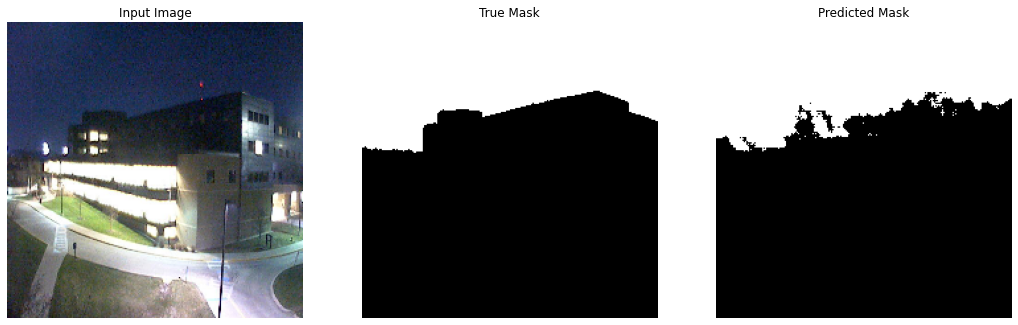

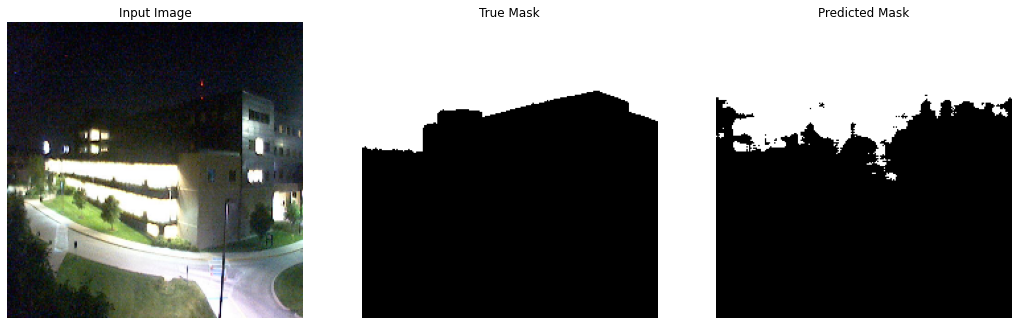

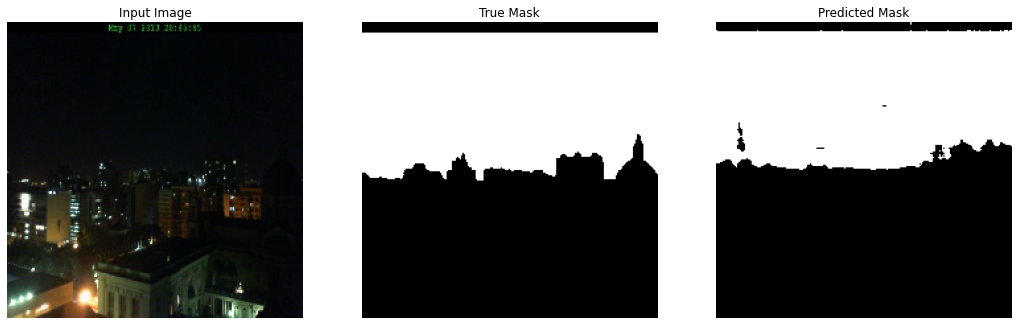

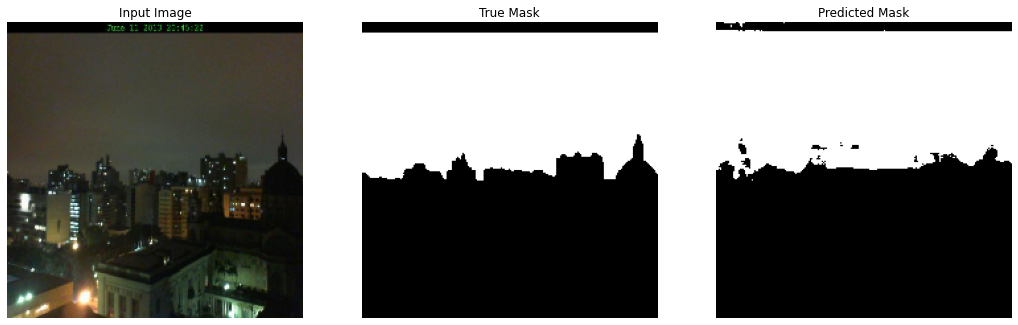

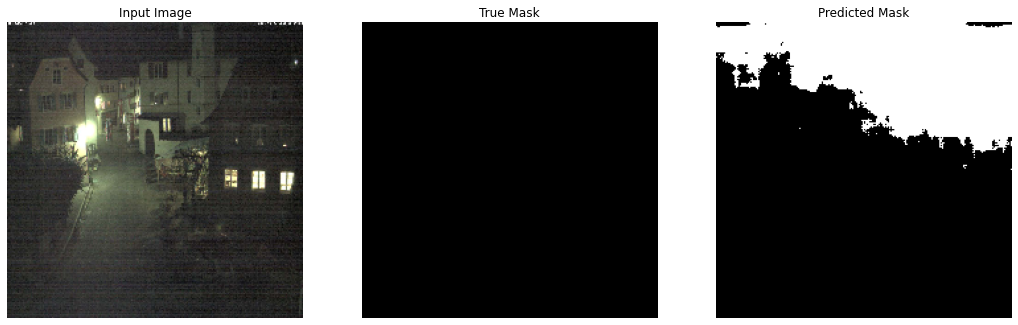


Sample Prediction after epoch 6

367/367 [==============================] - 636s 2s/step - loss: 0.0102 - accuracy: 0.9987 - mse: 0.4921 - val_loss: 0.0200 - val_accuracy: 0.9957 - val_mse: 0.4914


In [15]:
model_history = model.fit(train_gen, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_gen,
                          callbacks=[DisplayCallback(), lr_reduce])#, checkpoint])

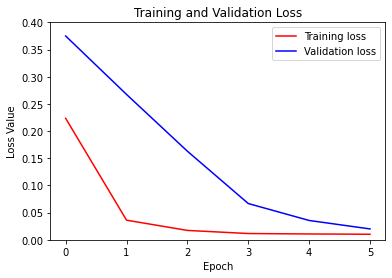

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.4])
plt.legend()
plt.show()

In [0]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

save_mod(model,"modelweights.h5","Model.json")

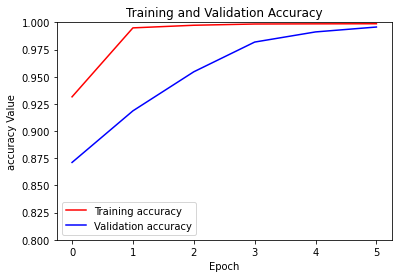

In [21]:
loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy Value')
plt.ylim([0.8, 1])
plt.legend()
plt.show()

In [0]:
save_mod(model,"/content/drive/My Drive/sky_segmentation/modelweights_1.h5","/content/drive/My Drive/sky_segmentation/Model_1.json")

0.9689891581632653
0.9314014668367347
0.9625119579081632
0.9747289540816326
0.7150829081632653


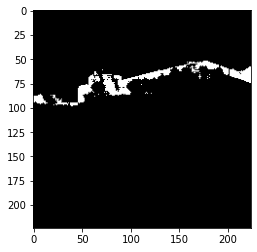

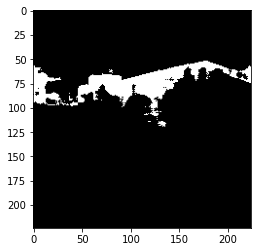

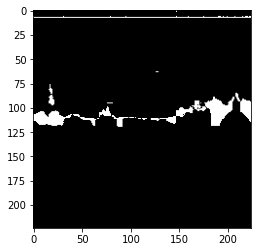

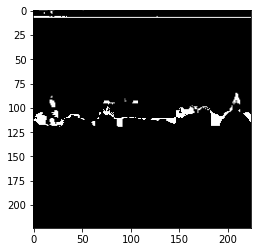

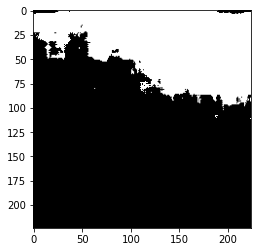

In [70]:
def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def find_acc():
    sample_imgs = ['1093-20140419_095406.jpg',
                   '1093-20140718_025356.jpg',
                   '5021-20130507_234643.jpg',
                   '5021-20130611_234627.jpg',
                   '10917-20110906_185406.jpg']
    sample_masks = ['1093.png', '1093.png', '5021.png', '5021.png', '10917.png']
    for sample_img, sample_msk in zip(sample_imgs, sample_masks):
        sample_image = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join('/content/drive/My Drive/sky_segmentation/test_img_1', sample_img)), cv2.COLOR_BGR2RGB), (224,224))/255.
        sample_mask = cv2.resize(cv2.imread(os.path.join('mask', sample_msk), 0), (224,224))
        pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        pred_mask = np.array(pred_mask, dtype=np.uint8)
        pred_mask = np.reshape(pred_mask, (224, 224))
        # print(type(sample_mask))
        incorrect = cv2.bitwise_xor(pred_mask, sample_mask)
        plt.figure()
        plt.imshow(incorrect, cmap='gray')
        acc = (224*224 - np.sum(incorrect))/ (224*224)
        print(acc)

find_acc()

In [0]:
def load_model():
    # Function to load and return neural network model 
    json_file = open('Model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights("model_weights.h5")
    return loaded_model